In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [43]:
import numpy as np
from pathlib import Path

from post.files import parse_metrics_log, parse_job_log
from post.plots import get_figa, plot_metrics, make_axis_great_again, plot_epochs

In [3]:
tesi_folder = Path('~/Scuola/now/thesis').expanduser()
milestones = tesi_folder / 'milestones'
current_milestone = milestones / '22.04_29.04_rototranslation_estimation'

found 79 / 79 training / validation epochs


Text(0.5, 0.98, 'Algebraic, lr=1e-5, 11872 / 703 images ~ 384 x 384 pixels')

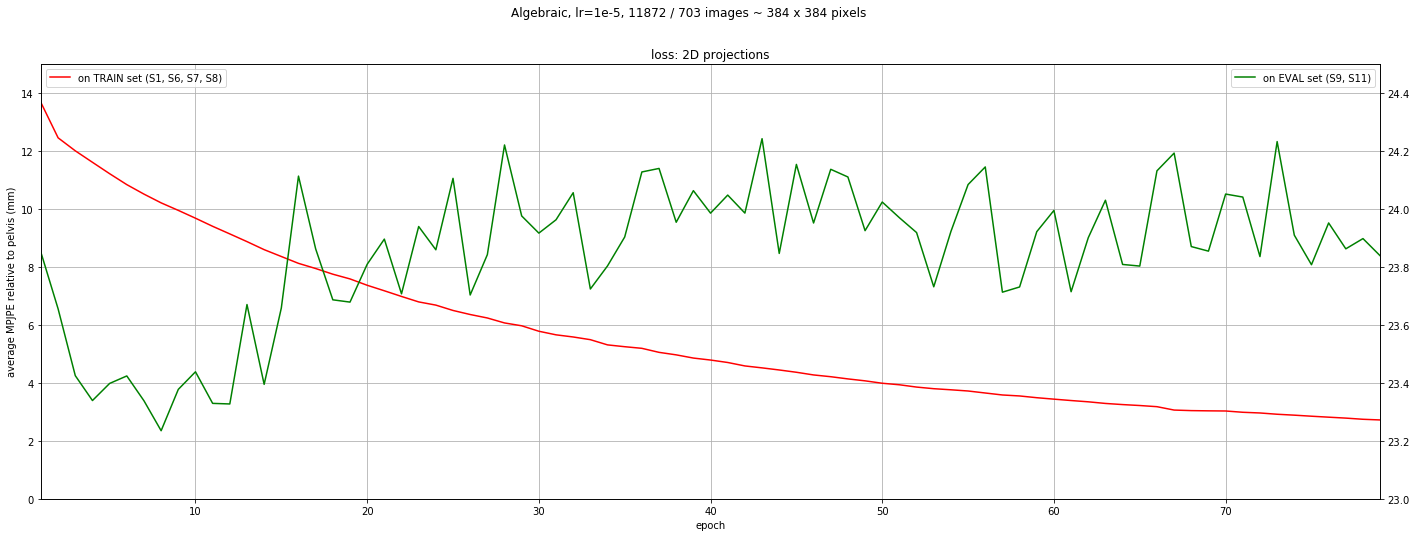

In [79]:
fig, axis = get_figa(1, 1, heigth=8, width=24)

train_ylim = [0, 15]
eval_ylim = [23, 24.5]

train_metrics, eval_metrics = parse_metrics_log(current_milestone / 'long.txt')
ax = axis  # .ravel()[0]
plot_metrics(ax, train_metrics, eval_metrics, train_ylim=train_ylim, eval_ylim=eval_ylim)
make_axis_great_again(
    ax,
    title='loss: 2D projections',
    left_title='average MPJPE relative to pelvis (mm)',
    xlim=[1, 79],
    ylim=train_ylim
)

# train_metrics, eval_metrics = parse_metrics_log(current_milestone / '2232.txt')
# ax = axis.ravel()[1]
# plot_metrics(ax, train_metrics, eval_metrics, train_ylim=train_ylim, eval_ylim=eval_ylim)
# make_axis_great_again(ax, 'loss on 3D KP', [0, 200], train_ylim)

fig.suptitle('Algebraic, lr=1e-5, 11872 / 703 images ~ 384 x 384 pixels')
# long.png

human36m_alg_AlgebraicTriangulationNet@28.04.2021-15:24:30 correctly parsed
training on 23, evaluating on 3
found 3962 epochs
training loss in [336116.6, 5321618.1]
training metrics in [292.4, 2999214.6]
eval metrics in [181.1, 633572.6]


Text(0.5, 0.98, 'cam2cam estimation on S1 (23 training / 3 validation images), using 2D GT projections, lr=1e-4')

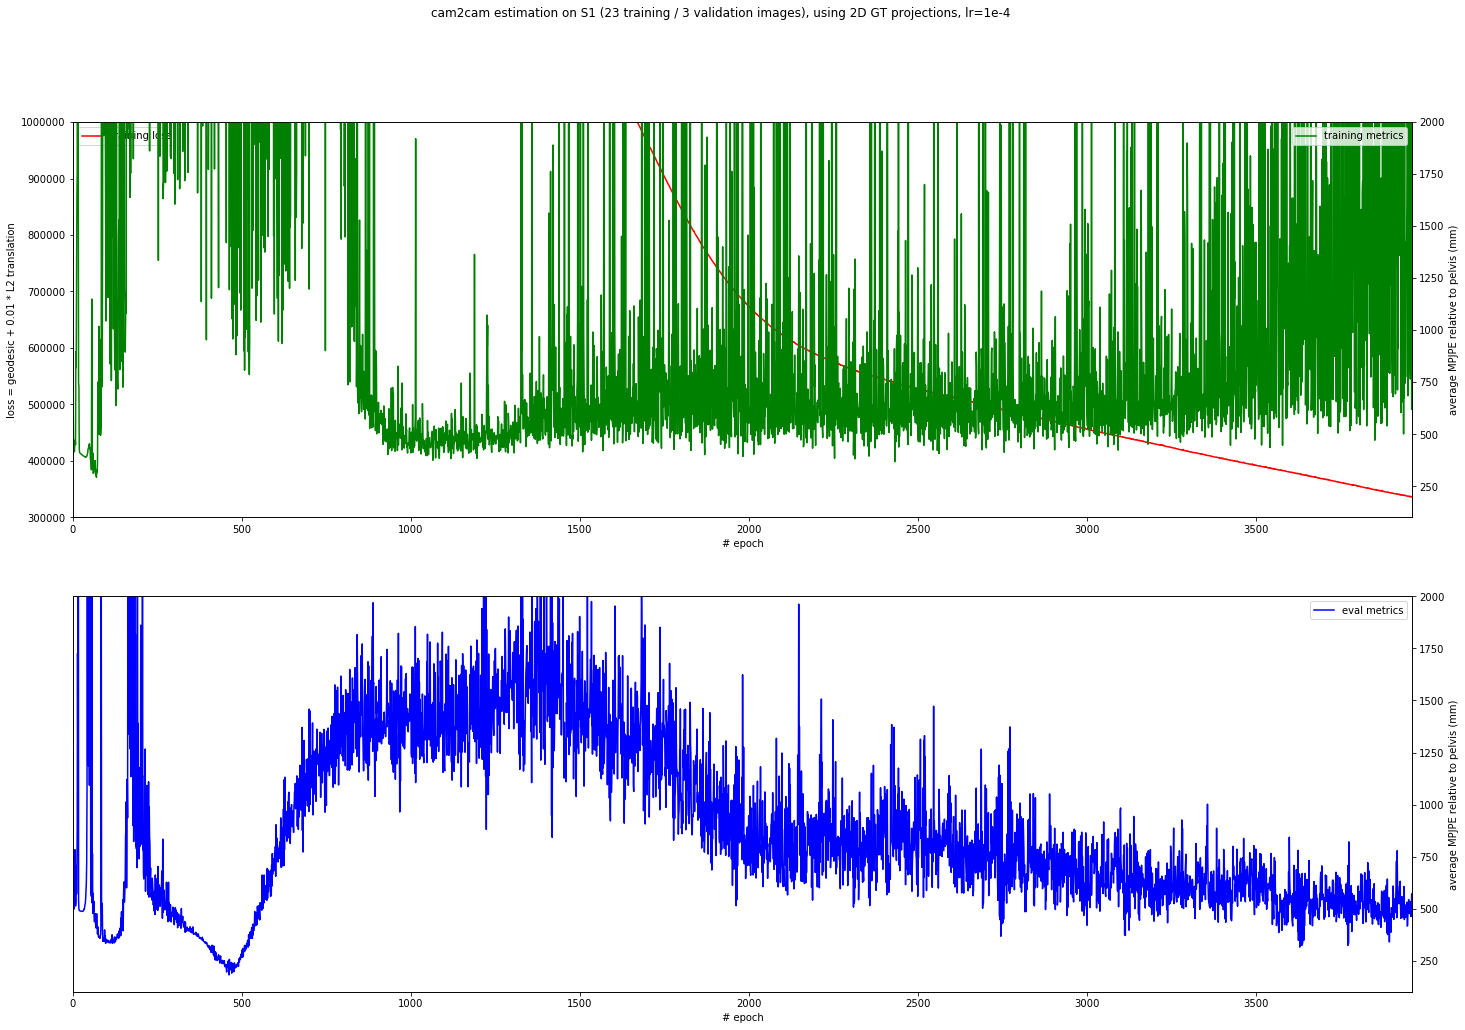

In [110]:
exp_name, train_data_amount, eval_data_amount, epochs = parse_job_log(current_milestone / '14193307.out')
fig, axis = get_figa(2, 1, heigth=8, width=24)

plot_epochs(
    axis, epochs,
    train_metric_ylim=[1e2, 20 * 1e2],
    eval_metric_ylim=[1e2, 20 * 1e2],
    loss_ylim=[3 * 1e5, 10 * 1e5],
    loss_ylabel='loss = geodesic + 0.01 * L2 translation',
    metric_ylabel='average MPJPE relative to pelvis (mm)'
)

fig.suptitle('cam2cam estimation on S1 (23 training / 3 validation images), using 2D GT projections, lr=1e-4')
# cam2cam.png